In [1]:
%matplotlib inline 
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import pickle
import collections
import time

#Utils Sklearn
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import OneHotEncoder

# ML
import xgboost as xgb
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.metrics import confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
# Neural Network
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.optimizers import SGD

# PLOT
import seaborn as sb
sb.set()
import sklearn.model_selection as sms 
import plotly.offline as pof
import plotly.graph_objs as go
import plotly.tools as ptools
pof.init_notebook_mode(connected=True)
import cufflinks as cf
cf.go_offline()

DATA_PATH_PROJET = "/Users/bguillouet/Insa/DeepLearning/data/HARWS/Projet/"
DATA_PATH_UCI = "/Users/bguillouet/Insa/DeepLearning/data/HARWS/UCI HAR Dataset/"

Using TensorFlow backend.


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


# Load Data

In [2]:
def make_dataframe(data_path, dtype = "train"):
    """
    Function to build train or test dataframe
    
    INPUT
    data_path = path of the directory of the original UCL Data
    dtype = either 'test' or 'train'
    
    OUTPUT
    X = the train or test DataFrame
    """
    data_path 
    
    # Read Column names files and convert it to a list
    with open(data_path +'features.txt', 'r') as content_file:
        features_names = content_file.read()
    columns_names = list(map(lambda x : x.split(" ")[1],features_names.split("\n")[:-1]))
    
    # Read the features files
    X = pd.read_csv(data_path + dtype + '/X_'+ dtype + '.txt', delim_whitespace=True, header=None, names=columns_names)
    
    # Read subject names and add it to the Features Data Frame
    with open(data_path + dtype + '/subject_'+ dtype + '.txt', 'r') as content_file:
        subject_train = content_file.read()
    X.loc[:,"subject"] = list(map(int,subject_train.split("\n")[:-1]))
    
    # Read response file and add it to the Feature DataFrame
    with open(data_path + dtype + '/y_'+ dtype + '.txt', 'r') as content_file:
        y = content_file.read()
    X.loc[:,"Activity"] = list(map(int,y.split("\n")[:-1]))
    
    return X

In [3]:
# Build Dictionary for metadata
# Télécharge les méta données si le fichier existe déjà
metadata_path = DATA_PATH_PROJET + "metadata_features_metier_prediction.pkl"
if os.path.isfile(metadata_path):
    metadata = pickle.load(open(metadata_path,"rb"))
else:
    metadata = {}

LABELS = ["WALKING","WALKING UPSTAIRS","WALKING DOWNSTAIRS","SITTING","STANDING","LAYING"]

# Make Data
train = make_dataframe(DATA_PATH_UCI, dtype = "train")
test = make_dataframe(DATA_PATH_UCI, dtype = "test")

X = train.values[:,:-1]
y = train.values[:,-1]

X_test = test.values[:,:-1]
y_test = test.values[:,-1]

train.head()



,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)",subject,Activity
0,0.288585,-0.020294,-0.132905,-0.995279,-0.983111,-0.913526,-0.995112,-0.983185,-0.923527,-0.934724,...,-0.710304,-0.112754,0.030400,-0.464761,-0.018446,-0.841247,0.179941,-0.058627,1,5
1,0.278419,-0.016411,-0.123520,-0.998245,-0.975300,-0.960322,-0.998807,-0.974914,-0.957686,-0.943068,...,-0.861499,0.053477,-0.007435,-0.732626,0.703511,-0.844788,0.180289,-0.054317,1,5
2,0.279653,-0.019467,-0.113462,-0.995380,-0.967187,-0.978944,-0.996520,-0.963668,-0.977469,-0.938692,...,-0.760104,-0.118559,0.177899,0.100699,0.808529,-0.848933,0.180637,-0.049118,1,5
3,0.279174,-0.026201,-0.123283,-0.996091,-0.983403,-0.990675,-0.997099,-0.982750,-0.989302,-0.938692,...,-0.482845,-0.036788,-0.012892,0.640011,-0.485366,-0.848649,0.181935,-0.047663,1,5
4,0.276629,-0.016570,-0.115362,-0.998139,-0.980817,-0.990482,-0.998321,-0.979672,-0.990441,-0.942469,...,-0.699205,0.123320,0.122542,0.693578,-0.615971,-0.847865,0.185151,-0.043892,1,5


# Learning Method

Pour chaque méthode (Logistic Regression, KNN, SVM, Random Forest, Adaboosd, Gradient Boosting, Xgbost) nous lançons un apprentissage avec les paramètres par défaut. 
Nous stockons dans les métadonnées, le modèle, le score sur l'échantillon test et le temps nécessaire a l'apprentissage

## Régression Logistique

In [4]:
key = 'Regression Logistique'
print(key)
if not(key in metadata.keys()):
    ts = time.time()
    print("start learning")
    method = LogisticRegression()
    method.fit(X,y)
    score = method.score(X_test, y_test)
    y_pred = method.predict(X_test)
    te = time.time()
    t_total = te-ts
    metadata.update({key : [method, score, y_pred, t_total]})
    pickle.dump(metadata, open(metadata_path,'wb'))

metadata_method = metadata[key]
print("Score : %f, time running : %d secondes" %(metadata_method[1], metadata_method[3]))
pd.DataFrame(confusion_matrix(y_test, metadata_method[2]), index = LABELS, columns=LABELS)

Regression Logistique
Score : 0.961317, time running : 5 secondes


,WALKING,WALKING UPSTAIRS,WALKING DOWNSTAIRS,SITTING,STANDING,LAYING
WALKING,494,0,2,0,0,0
WALKING UPSTAIRS,22,449,0,0,0,0
WALKING DOWNSTAIRS,5,8,407,0,0,0
SITTING,0,3,0,429,59,0
STANDING,2,0,0,13,517,0
LAYING,0,0,0,0,0,537


## KNN

In [5]:
key = 'knn'
print(key)
if not(key in metadata.keys()):
    ts = time.time()
    print("start learning")
    method = KNeighborsClassifier()
    method.fit(X,y)
    score = method.score(X_test, y_test)
    y_pred = method.predict(X_test)
    te = time.time()
    t_total = te-ts
    metadata.update({key : [method, score, y_pred, t_total]})
    pickle.dump(metadata, open(metadata_path,'wb'))

metadata_method = metadata[key]
print("Score : %f, time running : %d secondes" %(metadata_method[1], metadata_method[3]))
pd.DataFrame(confusion_matrix(y_test, metadata_method[2]), index = LABELS, columns=LABELS)

knn
Score : 0.807940, time running : 9 secondes


,WALKING,WALKING UPSTAIRS,WALKING DOWNSTAIRS,SITTING,STANDING,LAYING
WALKING,423,32,41,0,0,0
WALKING UPSTAIRS,101,344,26,0,0,0
WALKING DOWNSTAIRS,78,33,309,0,0,0
SITTING,0,2,0,332,157,0
STANDING,1,0,0,66,465,0
LAYING,0,0,0,20,9,508


## SVM

In [6]:

key = 'svm'
print(key)
if not(key in metadata.keys()):
    ts = time.time()
    print("start learning")
    method = SVC()
    method.fit(X,y)
    score = method.score(X_test, y_test)
    y_pred = method.predict(X_test)
    te = time.time()
    t_total = te-ts
    metadata.update({key : [method, score, y_pred, t_total]})
    pickle.dump(metadata, open(metadata_path,'wb'))

metadata_method = metadata[key]
print("Score : %f, time running : %d secondes" %(metadata_method[1], metadata_method[3]))
pd.DataFrame(confusion_matrix(y_test, metadata_method[2]), index = LABELS, columns=LABELS)

svm
Score : 0.930777, time running : 18 secondes


,WALKING,WALKING UPSTAIRS,WALKING DOWNSTAIRS,SITTING,STANDING,LAYING
WALKING,494,0,2,0,0,0
WALKING UPSTAIRS,23,446,2,0,0,0
WALKING DOWNSTAIRS,33,29,358,0,0,0
SITTING,0,2,0,421,68,0
STANDING,0,0,0,45,487,0
LAYING,0,0,0,0,0,537


## RandomForest

In [7]:
key = "random_forest_classifier"
if not(key in metadata.keys()):
    print("start learning")
    ts = time.time()
    method = RandomForestClassifier()
    method.fit(X,y)
    score = method.score(X_test, y_test)
    y_pred = method.predict(X_test)
    te = time.time()
    t_total = te-ts
    metadata.update({key : [method, score, y_pred, t_total]})
    pickle.dump(metadata, open(metadata_path,'wb'))
metadata_method = metadata[key]
print("Score : %f, time running : %d secondes" %(metadata_method[1], metadata_method[3]))
pd.DataFrame(confusion_matrix(y_test, metadata_method[2]), index = LABELS, columns=LABELS)

Score : 0.899898, time running : 1 secondes


,WALKING,WALKING UPSTAIRS,WALKING DOWNSTAIRS,SITTING,STANDING,LAYING
WALKING,481,8,7,0,0,0
WALKING UPSTAIRS,83,377,11,0,0,0
WALKING DOWNSTAIRS,32,39,349,0,0,0
SITTING,0,0,0,444,47,0
STANDING,0,0,0,67,465,0
LAYING,0,0,0,1,0,536


## AdaBoost

In [8]:
key = "AdaBoost_classifier"
print(key)
if not(key in metadata.keys()):
    print("start learning")
    ts = time.time()
    method = AdaBoostClassifier()
    method.fit(X,y)
    score = method.score(X_test, y_test)
    y_pred = method.predict(X_test)
    te = time.time()
    t_total=te-ts
    metadata.update({key : [method, score, y_pred, t_total]})
    pickle.dump(metadata, open(metadata_path,'wb'))
    
metadata_method = metadata[key]
print("Score : %f, time running : %d secondes" %(metadata_method[1], metadata_method[3]))
pd.DataFrame(confusion_matrix(y_test, metadata_method[2]), index = LABELS, columns=LABELS)

AdaBoost_classifier
Score : 0.531049, time running : 23 secondes


,WALKING,WALKING UPSTAIRS,WALKING DOWNSTAIRS,SITTING,STANDING,LAYING
WALKING,496,0,0,0,0,0
WALKING UPSTAIRS,471,0,0,0,0,0
WALKING DOWNSTAIRS,420,0,0,0,0,0
SITTING,0,0,0,0,491,0
STANDING,0,0,0,0,532,0
LAYING,0,0,0,0,0,537


## GradientBoosting

In [9]:
key = "GradientBoosting_classifier"
print(key)
if not(key in metadata.keys()):
    print("start learning")
    ts = time.time()
    method = GradientBoostingClassifier()
    method.fit(X,y)
    score = method.score(X_test, y_test)
    y_pred = method.predict(X_test)
    te = time.time()
    t_total = te-ts
    metadata.update({key : [method, score, y_pred, t_total]})
    pickle.dump(metadata, open(metadata_path,'wb'))
    
metadata_method = metadata[key]
print("Score : %f, time running : %d secondes" %(metadata_method[1], metadata_method[3]))
pd.DataFrame(confusion_matrix(y_test, metadata_method[2]), index = LABELS, columns=LABELS)

GradientBoosting_classifier
Score : 0.938582, time running : 180 secondes


,WALKING,WALKING UPSTAIRS,WALKING DOWNSTAIRS,SITTING,STANDING,LAYING
WALKING,487,6,3,0,0,0
WALKING UPSTAIRS,24,439,7,1,0,0
WALKING DOWNSTAIRS,7,27,385,0,1,0
SITTING,0,2,0,417,72,0
STANDING,0,0,0,31,501,0
LAYING,0,0,0,0,0,537


## XGBoost

In [10]:
key = "xgboost"
print(key)
if not(key in metadata.keys()):
    print("start learning")
    ts = time.time()
    method = xgb.XGBClassifier()
    method.fit(X,y)
    score = method.score(X_test, y_test)
    y_pred = method.predict(X_test)
    te = time.time()
    t_total = te-ts
    metadata.update({key : [method, score, y_pred, t_total]})
    pickle.dump(metadata, open(metadata_path,'wb'))
    
metadata_method = metadata[key]
print("Score : %f, time running : %d secondes" %(metadata_method[1], metadata_method[3]))
pd.DataFrame(confusion_matrix(y_test, metadata_method[2]), index = LABELS, columns=LABELS)

xgboost
Score : 0.938921, time running : 119 secondes


,WALKING,WALKING UPSTAIRS,WALKING DOWNSTAIRS,SITTING,STANDING,LAYING
WALKING,487,4,5,0,0,0
WALKING UPSTAIRS,25,441,5,0,0,0
WALKING DOWNSTAIRS,7,30,383,0,0,0
SITTING,0,3,0,417,71,0
STANDING,0,0,0,30,502,0
LAYING,0,0,0,0,0,537


## Neural Network

In [11]:
y_test.shape

(2947,)

In [12]:
key = "neural_network"
print(key)

# Keras ne permet pas de prendre un vecteur de dimension 1 avec l'indice du label.
# Il faut passer à la méthode une matrice de dimension n_individus x n_label, ou chaque colonne est une variable binaire correspondant a chaque variable.
# La fonction OneHotEncoder permet de facilement convertir y au bon format
ohe = OneHotEncoder()
y_ohe = ohe.fit_transform(y[:,np.newaxis]).toarray()
y_test_ohe = ohe.transform(y_test[:,np.newaxis]).toarray()


if not(key in metadata.keys()) or True:
    print("start learning")
    ts = time.time()
    
    model = Sequential()
    model.add(Dense(64, activation='relu', input_dim=562))
    model.add(Dense(6, activation='softmax'))
    sgd = SGD()
    model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])
    model.fit(X, y_ohe, epochs=30,batch_size=128)
    score = model.evaluate(X_test, y_test_ohe, batch_size=128)
    y_pred = model.predict(X_test, batch_size=128)
    te = time.time()
    t_total = te-ts
    model.save(DATA_PATH_PROJET+"model_keras.h5")
    metadata.update({key : ["", score, y_pred, t_total]})
    pickle.dump(metadata, open(metadata_path,'wb'))

metadata_method = metadata[key]
print("\nScore : %f, time running : %d secondes" %(metadata_method[1][1], metadata_method[3]))

y_pred_ = metadata_method[2].argmax(1)+1
pd.DataFrame(confusion_matrix(y_test, y_pred_), index = LABELS, columns=LABELS)

neural_network

Score : 0.915847, time running : 5 secondes


,WALKING,WALKING UPSTAIRS,WALKING DOWNSTAIRS,SITTING,STANDING,LAYING
WALKING,492,0,4,0,0,0
WALKING UPSTAIRS,14,457,0,0,0,0
WALKING DOWNSTAIRS,32,33,355,0,0,0
SITTING,0,3,0,351,136,1
STANDING,1,0,0,24,507,0
LAYING,0,0,0,0,0,537


# Plot Result

## Score classification

Résumé des résultats obtenues en faisant tourner les différentes méthodes avec leur paramètre par défaut

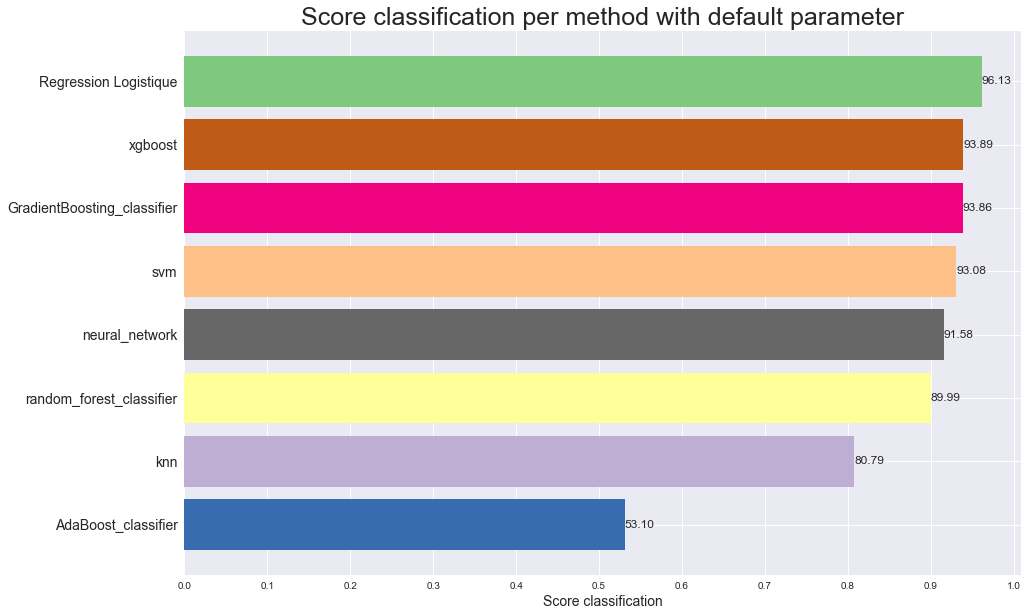

In [15]:
cmaps = plt.get_cmap("Accent")
color_dic = dict([(k,cmaps(i)) for i,k in enumerate(list(metadata.keys()))])

data_plot = [(k,v[1]) if k!= "neural_network" else( k,v[1][1])  for k,v in metadata.items() ]
data_plot_sorted = sorted(data_plot, key = lambda x : x[1])
nb_method = len(data_plot)

fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(111)
for i,(k,value) in enumerate(data_plot_sorted):
    ax.barh(i, value, color = color_dic[k])
    ax.text(value, i, "%.2f"%(value*100), ha='left', va='center')

# Set information label
ax.set_xticks(np.arange(0,1.1,0.1))
ax.set_yticks(range(nb_method))
ax.set_yticklabels(list([k[0] for k in data_plot_sorted]))
ax.set_xlabel("Score classification", fontsize=14)
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(14) 
ax.set_title("Score classification per method with default parameter", fontsize=25)



## Temps d'apprentissage

Résumé des résultats obtenues en faisant tourner les différentes méthodes avec leur paramètre par défaut

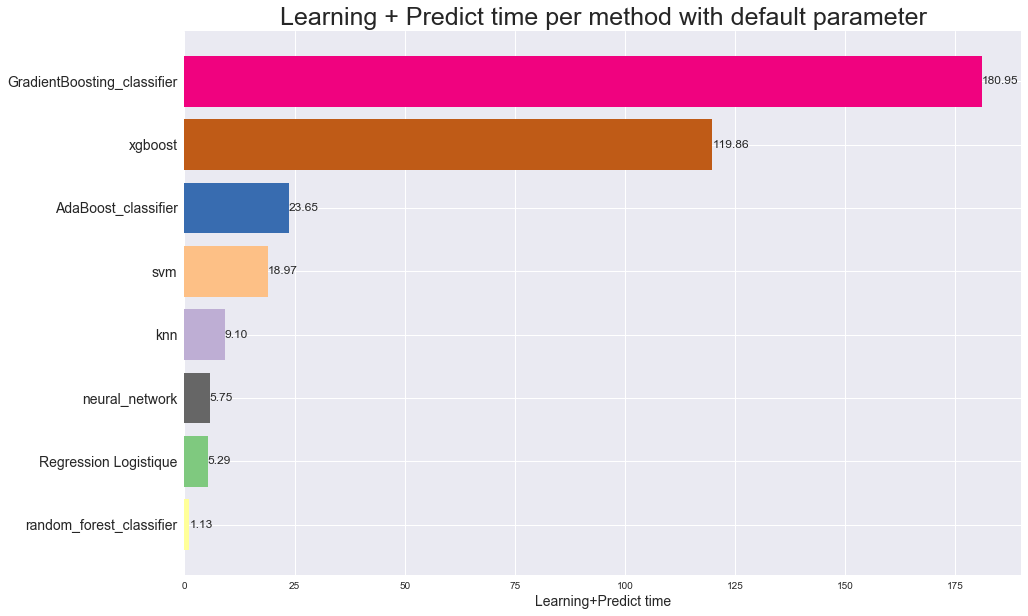

In [16]:
cmaps = plt.get_cmap("Accent")

data_plot = [(k,v[3]) for k,v in metadata.items() ]
data_plot_sorted = sorted(data_plot, key = lambda x : x[1])

fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(111)
for i,(k,value) in enumerate(data_plot_sorted):
    ax.barh(i, value, color = color_dic[k])
    ax.text(value, i, "%.2f"%value, ha='left', va='center')

# Set information label
ax.set_yticks(range(nb_method))
ax.set_yticklabels(list([k[0] for k in data_plot_sorted]))
ax.set_xlabel("Learning+Predict time", fontsize=14)

for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(14) 
ax.set_title("Learning + Predict time per method with default parameter", fontsize=25)
